<a href="https://colab.research.google.com/github/sejeong-park/Energy_Consumption/blob/main/Household_Electricity_Consumption_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from math import sqrt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error #MSE
from matplotlib import pyplot

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras import Model,layers
from keras.models import load_model, model_from_json


In [74]:
#split a univariate dataset into train/test sets
def split_dataset(data):
  #split into standard weeks
  train,test=data[1:-328],data[-328:-6]
  #restructure into windows of weekly data
  train=array(split(train,len(train)/7))
  test=array(split(test,len(test)/7))
  return train, test

In [75]:
#예측(실측값, 예측값)
def evaluate_forecasts(actual,predicted):
  scores=list()
  for i in range(actual.shape[1]):
    mse=mean_squared_error(actual[:,i],predicted[:,i])
    rmse=sqrt(mse)
    scores.append(rmse)

  s=0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s+=(actual[row,col]-predicted[row,col])**2
  score=sqrt(s/(actual.shape[0]*actual.shape[1]))
  return score,scores


In [76]:
def summarize_scores(name,score,scores):
  s_scores=','.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s'%(name,score,s_scores))

In [56]:
#convert history into inputs and outputs
def to_supervised(train,n_input,n_out=7):
  #flatten data
  data=train.reshape((train.shape[0]*train.shape[1],train.shape[2]))
  x,y=list(),list()
  in_start=0
  for _ in range(len(data)):
    in_end=in_start+n_input
    out_end=in_end+n_out
    if out_end<len(data):
      x.append(data[in_start:in_end,:])
      y.append(data[in_end:out_end, 0])
    in_start+=1
  return array(x),array(y)

In [77]:
# train the model
def build_and_train_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 1, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [84]:
def forecast(model,history,n_input):
  #flatten data
  data=array(history)
  data=data.reshape((data.shape[0]*data.shape[1],data.shape[2]))
  input_x=data[-n_input:,:]
  input_x=input_x.reshape((1,input_x.shape[0],input_x.shape[1]))
  yhat=model.predict(input_x,verbose=0)
  yhat=yhat[0]
  return yhat

In [79]:
def evaluate_model(train,test,n_input):
  model=build_and_train_model(train,n_input)
  model.save('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model.h5')
  model.save_weights('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model_Weight.h5')
  with open('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model_architecture.json','w') as f:
    f.write(model.to_json())
  
  history=[x for x in train]
  predictions=list()
  for i in range(len(test)):
    yhat_sequence=forecast(model,history,n_input)
    predictions.append(yhat_sequence)
    history.append(test[i,:])
  predictions=array(predictions)
  score,scores=evaluate_forecasts(test[:,:,0],predictions)
  return score,scores

In [80]:
# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_and_train_model(train, n_input)
    model.save('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model.h5')

    # architecture to JSON, weights to HDF5
    model.save_weights('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model_Weights.h5')
    with open('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model_architecture.json', 'w') as f:
            f.write(model.to_json())
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [81]:
def load_pretrained_model(train,test,n_input):
  model=load_model('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model.h5')

  with open('models/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_architecture.json') as f:
    model=model_from_json(f.read())
  model.load_weights('model/CNN_Encoder_LSTM_Decoder_Seq2Seq_Multivariate_Model_Weights.h5')

  history=[x for x in train]
  predictions=list()
  for i in range(len(test)):
    yhat_sequence=forecst(model,history,n_input)
    predictions.append(yhat_sequence)
    history.append(test[i,:])
  predictions=array(predictions)
  score,scores=evaluate_forecasts(test[:,:,0],predictions)
  return score, scores

In [82]:
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

In [85]:
train, test=split_dataset(dataset.values)
n_input=14
score, scores = evaluate_model(train, test, n_input)
summarize_scores('cnn-lstm',score,scores)
days_label=['sun','mon','tue','wed','thr','fri','sat']
days=[0,1,2,3,4,5,6]


Epoch 1/50
69/69 [==============================] - 3s 23ms/step - loss: 96896574.3429
Epoch 2/50
69/69 [==============================] - 2s 23ms/step - loss: 448340.3304
Epoch 3/50
69/69 [==============================] - 2s 23ms/step - loss: 375619.6469
Epoch 4/50
69/69 [==============================] - 2s 22ms/step - loss: 356044.4473
Epoch 5/50
69/69 [==============================] - 2s 23ms/step - loss: 355430.6223
Epoch 6/50
69/69 [==============================] - 2s 23ms/step - loss: 340849.7982
Epoch 7/50
69/69 [==============================] - 2s 23ms/step - loss: 365352.9281
Epoch 8/50
69/69 [==============================] - 2s 22ms/step - loss: 390763.2375
Epoch 9/50
69/69 [==============================] - 2s 23ms/step - loss: 349131.1357
Epoch 10/50
69/69 [==============================] - 2s 23ms/step - loss: 347048.7228
Epoch 11/50
69/69 [==============================] - 1s 22ms/step - loss: 342975.8487
Epoch 12/50
69/69 [==============================] - 2s 23ms/

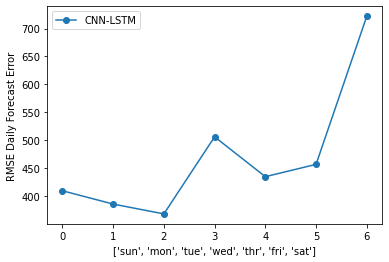

In [87]:
days_label=['sun','mon','tue','wed','thr','fri','sat']
days=[0,1,2,3,4,5,6]

pyplot.plot(days, scores,marker='o',label='CNN-LSTM')
pyplot.xlabel(days_label)
pyplot.ylabel('RMSE Daily Forecast Error')
pyplot.legend()
pyplot.show()